# 직접 해보기

1. 데이터 로드 및 전처리
    1. 필요없는 특수문자 제거
    1. 소문자화
    1. 형태소 분석기를 이용해 압축
    1. 단어사전 정의 및 생성
    1. 패딩
1. 데이터셋 정의
1. 모델 정의
    1. 레이어 정의
    1. 얼리 스토퍼 정의
    1. 전체 모델 정의
1. 학습/ 평가 함수 생성
1. 객체및 변수 생성
1. 학습/ 평가 실행
    1. 학습/ 평가 내용 시각화
1. 최종 평가 실행

In [ ]:
######################
# 모듈 임포트
######################
import numpy as np 
import pandas as pd 

import torch 
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader

from torch.autograd import Variable
from torchtext.vocab import build_vocab_from_iterator

from tqdm import tqdm

import spacy

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import time

tqdm.pandas()

######################
# 데이터 패스 정의
######################
try:
    from google.colab import drive
    
    drive.mount('/content/data')
    DATA_PATH = "/content/data/MyDrive/google_lecture/06. deep learning/3. NLP Pytorch/data/"
    MODEL_PATH = "/content/data/MyDrive/google_lecture/06. deep learning/3. NLP Pytorch/model/"
except:
    DATA_PATH = "/home/parking/ml/data/data/IMDB/"
    MODEL_PATH = "/home/parking/ml/data/models/IMDB/"


NUM_CORES: 20


## 클래스 정의

In [ ]:
######################
# 전처리 클래스 정의
######################
class ReviewDataPreprocessing():
    def __init__(self, df):
        # spacy 객체 생성
        self.nlp = spacy.load("en_core_web_sm")
        # vocab 생성
        print('set vocab')
        self.vocab = self.__set_vocab(df)
        # features 전처리 및 토큰화, 패딩
        print('set features')
        self.features = self.__featurs_processing(df)
        # targets 전처리
        print('set targets')
        self.targets = self.__targets_processing(df)
    
    def load_data(self):
        return self.features, self.targets
    
    def load_vocab(self):
        return self.vocab
    
    # vocab 생성 함수 정의
    def __set_vocab(self, df):
        # iterator 생성
        token_gen = self.__yield_tokens(df,
                                        self.__pretreatment_and_tokenizer,
                                        )
        # vocab 생성
        vocab = build_vocab_from_iterator(token_gen,  # iterator
                                        specials=["<pad>","<unk>"], # 특수 토큰
                                        )
        # unkonwn 토큰의 인덱스를 0으로 설정
        vocab.set_default_index(vocab["<unk>"])
        # vocab 반환
        return vocab
    
    # 피처 전처리 함수 정의
    def __featurs_processing(self, df):
        print('indexing')
        data = df['review'].progress_map(self.__tokens_to_index)
        print('padding')
        features = self.__padding(data)
        return np.array(features)
    
    # 타겟 전처리 함수 정의
    def __targets_processing(self, df):
        # 타겟 데이터만 추출
        targets = df['sentiment']
        # positive를 1, negative를 0으로 변환 후 numpy array로 변환
        targets = (targets=='positive').to_numpy().astype(int)
        return targets
    
    # iterator 정의
    def __yield_tokens(self, data, tokenizer):
        print('tokenizing')
        data['review'] = data['review'].progress_map(tokenizer)
        print('build vocab')
        for token in tqdm(data['review']):
            yield token
        
    # 인덱싱 함수 정의
    def __tokens_to_index(self, tokens):
        return [self.vocab[token] for token in tokens]
    
    # 전처리 및 토큰화 함수 정의
    def __pretreatment_and_tokenizer(self, text):
        # 공백 제거
        text = text.strip()
        # 소문자로 변환
        text = text.lower() 
        # <br /> 태그 제거
        text = text.replace('<br />', '')
        # 형태소 분석기를 통한 토큰화
        doc = self.nlp(text)
        # 명사, 동사, 형용사만 토큰화
        return [token.lemma_ for token in doc if token.tag_[0] in "NVJ"]

    # 패딩 함수 정의
    def __padding(self, features):
        # 최대 길이 계산
        max_len = max(len(feature) for feature in features)
        padding_features = []
        for feature in tqdm(features):
            # 패딩
            padding_feature = feature + [0] * (max_len - len(feature))
            # 패딩된 데이터를 리스트에 저장
            padding_features.append(padding_feature)
        return padding_features

In [ ]:
######################
# 데이터셋 정의
######################
class ReviewDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.int64)
        if self.y is not None:
            y = torch.tensor(self.y[idx], dtype=torch.float32)
        return X, y

In [ ]:
######################
# 레이어 클래스 정의
######################
# 임베딩 레이어 클래스 정의
class EmbeddingLayer(nn.Module):
    def __init__(self, n_class, embedding_size=128):
        super().__init__()
        self.emb_layer = nn.Embedding(n_class,    # n_class
                                    embedding_size, # output_size = embedding_size
                                    )

    def forward(self, X):
        return self.emb_layer(X)
# LSTM 레이어 클래스 정의
class LSTMLayer(nn.Module):
    def __init__(self, embedding_size=128, hidden_size=128, num_layers=3, is_bidirectional=True):
        super().__init__()
        # 변수 저장
        self.shape_size = (2 if is_bidirectional else 1) * num_layers
        self.hidden_size = hidden_size
        
        self.lstm_layer = nn.LSTM(input_size=embedding_size, # input_size = embedding_size
                                hidden_size=hidden_size,    # 은닉층의 갯수
                                num_layers=num_layers,      # 은닉층 각각의 레이어 갯수
                                bidirectional=is_bidirectional,  # 양방향 LSTM 여부
                                )
        
    def forward(self, X):
        # 축교환
        _X = X.transpose(0, 1)
        # hidden_state의 마지막 값만 반환
        output_raw = self.__get_hidden_state(_X, len(X))
        return output_raw
        
    def __get_hidden_state(self, X, lenght):
        # hidden_state와 cell_state의 shape 정의
        shape = (self.shape_size, lenght, self.hidden_size)
        # hidden_state와 cell_state를 초기화
        hidden_state = torch.zeros(shape).to(X.device)
        cell_state = torch.zeros(shape).to(X.device)
        # LSTM 레이어를 통해 output과 hidden_state, cell_state를 반환
        _, (hidden_state, __) = self.lstm_layer(X, (hidden_state, cell_state))
        return hidden_state[-1]
# 이진 출력 레이어 클래스 정의
class BinaryOutputLayer(nn.Module):
    def __init__(self, input_size=128):
        super().__init__()
        self.output_layer = nn.Sequential(
            # 데이터의 양을 반으로 줄임
            nn.Linear(input_size, input_size//2, bias=False),
            # 활성화 함수
            nn.ReLU(),
            # 출력 데이터의 양을 1로 줄임
            nn.Linear(input_size//2, 1, bias=False),
            # 이진분류 이므로 시그모이드 함수를 통해 0~1사이의 값으로 변환
            nn.Sigmoid(),
            )
        
    def forward(self, X):
        return self.output_layer(X)

In [ ]:
######################
# 얼리 스토핑 클래스 정의
######################
class EarlyStopping():
    def __init__(self, patience=10, save_path=None, target_score=0):
        # 초기화
        self.best_score = 0
        self.patience_count = 0
        self.target_score = target_score
        self.patience = patience
        self.save_path = save_path
        self.datetime = time.strftime
    # 얼리 스토핑 여부 확인 함수 정의
    def is_stop(self, model, score, epoch):
        # 모델 저장(마지막 모델)
        self.__save_last_model(model)
        # 스코어가 타겟 스코어보다 낮을 경우
        if score < self.target_score:
            # patience 초기화
            self.patience_count = 0
            return False
        
        # 스코어가 이전보다 좋을 경우
        if self.best_score < score:
            # 스코어를 업데이트
            self.best_score = score
            # 모델 저장
            self.__save_model(model, epoch)
            # patience 초기화
            self.patience_count = 0
            return False
        
        # 스코어가 이전보다 좋지 않을 경우 +
        # 스코어가 타겟 스코어보다 높을 경우
        # patience 증가
        self.patience_count += 1
        # patience가 최대치를 넘을 경우
        if self.patience_count > self.patience:
            return True
        # patience가 최대치를 넘지 않을 경우
        return False
    # 모델 저장 함수 정의
    def __save_model(self, model, epoch):
        model_name = f'IMDB_model_{self.datetime("%m%d_%H%M")}_{epoch+1:04d}.pth'
        torch.save(model.state_dict(), self.save_path + model_name)
    # 마지막 모델 저장 함수 정의
    def __save_last_model(self, model):
        model_name = f'IMDB_model_last.pth'
        torch.save(model.state_dict(), self.save_path + model_name)

In [ ]:
######################
# 모델 정의
######################
class IMDBReviewPNModel(nn.Module):
    def __init__(self, n_class, embedding_size=128, hidden_size=128, num_layers=3, is_bidirectional=True):
        super().__init__()
        self.seq = nn.Sequential(
            # 임베딩 레이어
            EmbeddingLayer(n_class=n_class,
                        embedding_size=embedding_size,
                        ),
            # LSTM 레이어
            LSTMLayer(embedding_size=embedding_size,
                        hidden_size=hidden_size,
                        num_layers=num_layers,
                        is_bidirectional=is_bidirectional,
                        ),
            # 이진 아웃풋 레이어
            BinaryOutputLayer(
                        input_size=hidden_size
                        ),
        )
            
    def forward(self, X):
        return self.seq(X)

In [ ]:
######################
# 학습 함수 정의
######################
def train_loop(dataloader, model, loss_fn, optimizer, device, threshold=0.5):
    # 손실값 초기화
    loss_list = []
    score_list = []
    # 모델을 학습 모드로 설정
    model.train()
    # 배치 단위로 학습
    for X, y in dataloader:
        # 데이터를 디바이스에 할당
        X = X.to(device)
        y = y.reshape(-1,1).to(device)
        # 모델을 통해 예측
        pred = model(X)
        # pred값 클래스로 변환
        pred_class = (pred > threshold).to(torch.int64)
        # 손실값 계산
        loss = loss_fn(pred, y)
        # 기울기 초기화
        optimizer.zero_grad()
        # 역전파
        loss.backward()
        # 가중치 업데이트
        optimizer.step()
        # 손실값을 리스트에 저장
        loss_list.append(loss.item())
        # 정확도를 리스트에 저장
        score_list.append(accuracy_score(pred_class.cpu().detach().numpy(),
                                        y.cpu().numpy(),
                                        ))
    # 손실값 평균 계산
    loss_mean = np.mean(loss_list)
    # 정확도 평균 계산
    score_mean = np.mean(score_list)
    # 손실값 평균, 정확도 평균 반환
    return loss_mean, score_mean

######################
# 평가 함수 정의
######################
@torch.inference_mode()
def test_loop(dataloader, model, device, threshold=0.5):
    # 저장값 초기화
    score_list = []
    # 모델을 평가 모드로 설정
    model.eval()
    # 배치 단위로 평가
    for X, y in dataloader:
        # 데이터를 디바이스에 할당
        X = X.to(device)
        y = y.reshape(-1,1).to(device)
        # 모델을 통해 예측
        pred = model(X)
        # 예측값을 클래스로 변환
        pred_class = (pred > threshold).to(torch.int64)
        # 정확도를 리스트에 저장
        score_list.append(accuracy_score(pred_class.cpu().detach().numpy(),
                                        y.cpu().numpy(),
                                        ))
    # 정확도 평균 계산
    score_mean = np.mean(score_list)
    # 정확도 평균 반환
    return score_mean

######################
# epoch 학습 함수 정의
######################
def epoch_loop(train_dataloader, valid_dataloader, model, loss_fn, optimizer, device, threshold=0.5):
    # 학습
    train_loss, train_score = train_loop(train_dataloader, model, loss_fn, optimizer, device, threshold)
    # 평가
    valid_score = test_loop(valid_dataloader, model, device, threshold)
    # 손실값 평균, 정확도 평균 반환
    return train_loss, train_score, valid_score

# 모듈화 이후

## 데이터 정의

In [ ]:
######################
# 모듈 임포트
######################
from modules.IMDB import *

######################
# 데이터 로드
######################    
df_en = pd.read_csv(DATA_PATH+"IMDB-Dataset.csv")
# df_en = df_en[:500]

######################
# 객체 및 변수 생성
######################
# 데이터 전처리 객체 생성
preprocessing_module = ReviewDataPreprocessing(df_en)
# 데이터 로드
features, targets = preprocessing_module.load_data()
# vocab 로드
vocab = preprocessing_module.load_vocab()

set vocab
tokenizing


100%|██████████| 50000/50000 [18:12<00:00, 45.77it/s]


build vocab


100%|██████████| 50000/50000 [00:00<00:00, 92593.09it/s]


set features
indexing


100%|██████████| 50000/50000 [00:02<00:00, 19650.53it/s]


padding


100%|██████████| 50000/50000 [00:00<00:00, 76064.41it/s]


set targets


In [ ]:
######################
# feature, target , vocab 저장
######################
import pickle as pkl
# feature 저장
np.save(DATA_PATH+'features.npy', features)
# target 저장
np.save(DATA_PATH+'targets.npy', targets)
# vocab 저장
with open(DATA_PATH+'vocab.pkl', 'wb') as f:
    pkl.dump(vocab, f)

## 전처리된 데이터 로드

In [1]:
######################
# 모듈 임포트
######################
from modules.IMDB import *

(features, targets), vocab = load_IMDB_data()

######################
# 데이터셋 나누기
######################
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    targets,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=1473032201,
                                                    stratify=targets,
                                                    )

In [2]:
######################
# 상수 정의
######################
# 단어(클래스) 갯수
N_CLASS = len(vocab)
# 에폭 수
N_EPOCHS = 100
# 배치 크기
BATCH_SIZE = 1000
# 임베딩 차원 수 (임베딩된 단어의 벡터 차원 수)
EMBEDDING_SIZE = 128
# LSTM 레이어 은닉층의 차원 수
HIDDEN_SIZE = 10
# LSTM 레이어 은닉층 각각의 레이어 갯수
NUM_LAYERS = 3
# LSTM 레이어 양방향 여부
IS_BIDIRECTIONAL = True
# 학습률
LR = 0.001
# 얼리 스토핑 횟수
PATIENCE = 10
# 얼리 스토핑 타겟 스코어
TARGET_SCORE = 0.75
# 쓰레시 홀드(이진분류 기준)
THRES_HOLD = 0.5

# 디바이스 설정
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CPU = 'cpu'

# 얼리 스토핑 객체 생성
early_stopping = EarlyStopping(patience=PATIENCE,
                            save_path=MODEL_PATH,
                            target_score=TARGET_SCORE,
                            )

# 모델 객체 생성
model = IMDBReviewPNModel(n_class=N_CLASS,
                        embedding_size=EMBEDDING_SIZE,
                        hidden_size=HIDDEN_SIZE,
                        num_layers=NUM_LAYERS,
                        is_bidirectional=IS_BIDIRECTIONAL,
                        ).to(DEVICE)

# 손실함수 객체 생성
loss_fn = torch.nn.BCELoss()

# optimizer 객체 생성
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# K-Fold 객체 생성
from sklearn.model_selection import KFold
cv = KFold(n_splits=5, shuffle=True, random_state=1473032201)

In [4]:
######################
# 학습
######################
# 전체 손실값 및 정확도 저장 딕셔너리
loss_score_dict = {
    'train_loss':[],
    'train_score':[],
    'valid_score':[],
}
# 에폭 수 만큼 학습
for epoch in tqdm(range(N_EPOCHS)):
    # 손실값 및 정확도 초기화
    train_loss_list = []
    train_score_list = []
    valid_score_list = []
    # K-Fold를 통한 학습 및 평가
    for i, (tri, vai) in enumerate(cv.split(X_train)):
        # 데이터셋 생성
        train_dataset = ReviewDataset(X_train[tri], y_train[tri])
        valid_dataset = ReviewDataset(X_train[vai], y_train[vai])
        # 데이터로더 생성
        train_dataloader = DataLoader(train_dataset,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    drop_last=True,
                                    )
        valid_dataloader = DataLoader(valid_dataset,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    )
        # epoch 학습
        loss_and_scores = epoch_loop(train_dataloader,
                                    valid_dataloader,
                                    model,
                                    loss_fn,
                                    optimizer,
                                    DEVICE,
                                    THRES_HOLD,
                                    )
        train_loss, train_score, valid_score = loss_and_scores
        # 손실값 및 정확도 저장
        train_loss_list.append(train_loss)
        train_score_list.append(train_score)
        valid_score_list.append(valid_score)
    # epoch 손실값 및 정확도 계산
    train_loss_mean = np.mean(train_loss_list)
    train_score_mean = np.mean(train_score_list)
    valid_score_mean = np.mean(valid_score_list)
    # epoch 손실값 및 정확도 저장
    loss_score_dict['train_loss'].append(train_loss_mean)
    loss_score_dict['train_score'].append(train_score_mean)
    loss_score_dict['valid_score'].append(valid_score_mean)
    # 얼리 스토핑
    if early_stopping.is_stop(model, valid_score_mean, epoch):
        print(f'Early Stopping at {epoch+1} epoch')
        break

 63%|██████▎   | 63/100 [33:19<19:34, 31.74s/it]

Early Stopping at 64 epoch


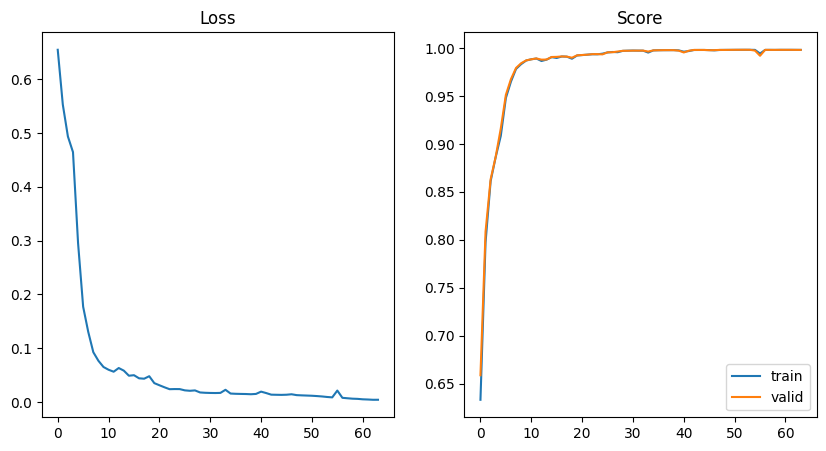

In [5]:
######################
# 학습 결과 시각화
######################
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# 손실값 시각화
axes[0].plot(loss_score_dict['train_loss'])
axes[0].set_title('Loss')
# 정확도 시각화
axes[1].plot(loss_score_dict['train_score'], label='train')
axes[1].plot(loss_score_dict['valid_score'], label='valid')
axes[1].set_title('Score')
axes[1].legend()
# 그래프 출력
plt.show()

In [3]:
######################
# 저장된 모델 로드
######################
# 모델 로드
best_model = IMDBReviewPNModel(n_class=N_CLASS,
                            embedding_size=EMBEDDING_SIZE,
                            hidden_size=HIDDEN_SIZE,
                            num_layers=NUM_LAYERS,
                            is_bidirectional=IS_BIDIRECTIONAL,
                            ).to(DEVICE)

best_model.load_state_dict(torch.load(MODEL_PATH+'IMDB_model_best.pth'))

<All keys matched successfully>

In [6]:
######################
# 평가
######################
# 데이터셋 생성
test_dataset = ReviewDataset(X_test, y_test)
# 데이터로더 생성
test_dataloader = DataLoader(test_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            )
# 평가
test_score = test_loop(test_dataloader,
                        best_model,
                        DEVICE,
                        )

In [7]:
######################
# 결과 출력
######################
print(f'Test Score: {test_score:.4f}')


Test Score: 0.8260
